시작하기 전에 구글 드라이브 마운트 필수

In [ ]:
# 현재 코랩 파이썬 버전 확인
!python --version

Python 3.6.9


In [ ]:
# python 3.6 버전 다운그레이드 -> 설치 후 버전 확인
!wget https://www.python.org/ftp/python/3.6.9/Python-3.6.9.tgz
!tar xvfz Python-3.6.9.tgz
!Python-3.6.9/configure
!make
!sudo make install

Streaming output truncated to the last 5000 lines.
Compiling '/usr/local/lib/python3.6/encodings/iso8859_2.py'...
Compiling '/usr/local/lib/python3.6/encodings/iso8859_3.py'...
Compiling '/usr/local/lib/python3.6/encodings/iso8859_4.py'...
Compiling '/usr/local/lib/python3.6/encodings/iso8859_5.py'...
Compiling '/usr/local/lib/python3.6/encodings/iso8859_6.py'...
Compiling '/usr/local/lib/python3.6/encodings/iso8859_7.py'...
Compiling '/usr/local/lib/python3.6/encodings/iso8859_8.py'...
Compiling '/usr/local/lib/python3.6/encodings/iso8859_9.py'...
Compiling '/usr/local/lib/python3.6/encodings/johab.py'...
Compiling '/usr/local/lib/python3.6/encodings/koi8_r.py'...
Compiling '/usr/local/lib/python3.6/encodings/koi8_t.py'...
Compiling '/usr/local/lib/python3.6/encodings/koi8_u.py'...
Compiling '/usr/local/lib/python3.6/encodings/kz1048.py'...
Compiling '/usr/local/lib/python3.6/encodings/latin_1.py'...
Compiling '/usr/local/lib/python3.6/encodings/mac_arabic.py'...
Compiling '/usr/local

In [ ]:
cd /content/drive/MyDrive/BGNet

In [ ]:
# requirement.txt 다운
!pip install -r requirement.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
    100% |████████████████████████████████| 734.6MB 62kB/s 
    100% |████████████████████████████████| 10.2MB 3.9MB/s 
    100% |████████████████████████████████| 25.0MB 1.9MB/s 
    100% |████████████████████████████████| 81kB 33.4MB/s 
    100% |████████████████████████████████| 3.3MB 20.2MB/s 
    100% |████████████████████████████████| 13.4MB 5.2MB/s 
    100% |████████████████████████████████| 49.4MB 966kB/s 
    100% |████████████████████████████████| 25.9MB 2.1MB/s 
  Running setup.py install for pillow ... done


Train 시작.
- image_root 등에서 우리 데이터셋에 맞게 파일 이름 바꿔줬습니다.
- train dataset 경로 바꿔줬습니다.
- parser 는 주피터 노트북에서 호환되기 때문에 오류가 발생! 그래서 하단의 Parser 부분을 구글링해서 바꿔줬습니다! (easydict)
- 모델은 checkpoints 에 BGNet_try 로 저장했습니다.

In [ ]:
!pip install easydict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from torch.autograd import Variable
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import argparse
from datetime import datetime
from net.bgnet import Net
from utils.tdataloader import get_loader
from utils.utils import clip_gradient, AvgMeter, poly_lr
import torch.nn.functional as F
import numpy as np
import easydict


file = open("log/BGNet_try4.txt", "a")    # 새걸로 바꿔주기
torch.manual_seed(2025)
torch.cuda.manual_seed(2025)
np.random.seed(2025)
torch.backends.cudnn.benchmark = True


def structure_loss(pred, mask):
    weit = 1 + 5 * torch.abs(F.avg_pool2d(mask, kernel_size=31, stride=1, padding=15) - mask)
    wbce = F.binary_cross_entropy_with_logits(pred, mask, reduction='mean')
    wbce = (weit * wbce).sum(dim=(2, 3)) / weit.sum(dim=(2, 3))

    pred = torch.sigmoid(pred)
    inter = ((pred * mask) * weit).sum(dim=(2, 3))
    union = ((pred + mask) * weit).sum(dim=(2, 3))
    wiou = 1 - (inter + 1) / (union - inter + 1)
    return (wbce + wiou).mean()


def dice_loss(predict, target):
    smooth = 1
    p = 2
    valid_mask = torch.ones_like(target)
    predict = predict.contiguous().view(predict.shape[0], -1)
    target = target.contiguous().view(target.shape[0], -1)
    valid_mask = valid_mask.contiguous().view(valid_mask.shape[0], -1)
    num = torch.sum(torch.mul(predict, target) * valid_mask, dim=1) * 2 + smooth
    den = torch.sum((predict.pow(p) + target.pow(p)) * valid_mask, dim=1) + smooth
    loss = 1 - num / den
    return loss.mean()


def train(train_loader, model, optimizer, epoch):
    model.train()

    loss_record3, loss_record2, loss_record1, loss_recorde = AvgMeter(), AvgMeter(), AvgMeter(), AvgMeter()
    for i, pack in enumerate(train_loader, start=1):
        optimizer.zero_grad()
        # ---- data prepare ----
        images, gts, edges = pack
        images = Variable(images).cuda()
        gts = Variable(gts).cuda()
        edges = Variable(edges).cuda()
        # ---- forward ----
        lateral_map_3, lateral_map_2, lateral_map_1, edge_map = model(images)
        # ---- loss function ----
        loss3 = structure_loss(lateral_map_3, gts)
        loss2 = structure_loss(lateral_map_2, gts)
        loss1 = structure_loss(lateral_map_1, gts)
        losse = dice_loss(edge_map, edges)
        loss = loss3 + loss2 + loss1 + 3*losse
        # ---- backward ----
        loss.backward()
        clip_gradient(optimizer, opt.clip)
        optimizer.step()
        # ---- recording loss ----
        loss_record3.update(loss3.data, opt.batchsize)
        loss_record2.update(loss2.data, opt.batchsize)
        loss_record1.update(loss1.data, opt.batchsize)
        loss_recorde.update(losse.data, opt.batchsize)
        # ---- train visualization ----
        if i % 60 == 0 or i == total_step:
            print('{} Epoch [{:03d}/{:03d}], Step [{:04d}/{:04d}], '
                  '[lateral-3: {:.4f}], [lateral-2: {:.4f}], [lateral-1: {:.4f}], [edge: {:,.4f}]'.
                  format(datetime.now(), epoch, opt.epoch, i, total_step,
                         loss_record3.avg, loss_record2.avg, loss_record1.avg, loss_recorde.avg))
            file.write('{} Epoch [{:03d}/{:03d}], Step [{:04d}/{:04d}], '
                       '[lateral-3: {:.4f}], [lateral-2: {:.4f}], [lateral-1: {:.4f}], [edge: {:,.4f}]\n'.
                       format(datetime.now(), epoch, opt.epoch, i, total_step,
                         loss_record3.avg, loss_record2.avg, loss_record1.avg, loss_recorde.avg))

    save_path = 'checkpoints/{}/'.format(opt.train_save)
    os.makedirs(save_path, exist_ok=True)
    if (epoch + 1) % 5 == 0 or (epoch + 1) == opt.epoch:
        torch.save(model.state_dict(), save_path + 'BGNet-%d.pth' % epoch)
        print('[Saving Snapshot:]', save_path + 'BGNet-%d.pth' % epoch)
        file.write('[Saving Snapshot:]' + save_path + 'BGNet-%d.pth' % epoch + '\n')



if __name__ == '__main__':
    # 수정부분
    # Train (1) data 그대로 사용해서 try4 진행
    opt = easydict.EasyDict({
        "epoch" : 25,
        "train_path" : "/content/drive/MyDrive/Dataset/Train",
        "lr" : 1e-4,
        "batchsize" : 16,
        "trainsize" : 416,
        "clip" : 0.5,
        "train_save" : 'BGNet_try4'
    })



    # ---- build models ----
    model = Net().cuda()

    params = model.parameters()
    optimizer = torch.optim.Adam(params, opt.lr)

    # 수정부분
    image_root = '{}/Img/'.format(opt.train_path)
    gt_root = '{}/Mask/'.format(opt.train_path)
    edge_root = '{}/Edge/'.format(opt.train_path)


    train_loader = get_loader(image_root, gt_root, edge_root, batchsize=opt.batchsize, trainsize=opt.trainsize)
    total_step = len(train_loader)

    print("Start Training")

    for epoch in range(opt.epoch):
        poly_lr(optimizer, opt.lr, epoch, opt.epoch)
        train(train_loader, model, optimizer, epoch)

    file.close()


ModuleNotFoundError: ignored

Fine-tuning

COD10K, CAMO 등등으로 학습된 BGNet의 BGNet.pth 를 사용해서 우리의 블랙아이스 데이터로 fine tuning 을 실행

In [ ]:
# cd /content/drive/MyDrive/BGNet/net

/content/drive/MyDrive/BGNet/net


In [ ]:
import torch
from torch.autograd import Variable
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import argparse
from datetime import datetime

from utils.tdataloader import get_loader
from utils.utils import clip_gradient, AvgMeter, poly_lr
import torch.nn.functional as F
import numpy as np
import easydict
import torch.nn as nn

# 수정부분
# 기존 net.bgnet 파일 사용하던 것에서 net.bgnet_freeze_until_EFM 파일로 변경
# -> EFM 까지 동결

# from net.bgnet import Net
# from net.bgnet_freeze_until_EFM import Net
# from net.bgnet_freeze_until_EAM import Net
# from net.bgnet_freeze_only_backbone import Net
# from net.bgnet_MobileNet import Net
# from net.bgnet_new_mobilenet import Net





# 수정부분 : log 파일 이름
file = open("log/BGNet_FT_AG_MobileNet.txt", "a")
torch.manual_seed(2029)
torch.cuda.manual_seed(2029)
np.random.seed(2029)
torch.backends.cudnn.benchmark = True


def structure_loss(pred, mask):
    weit = 1 + 5 * torch.abs(F.avg_pool2d(mask, kernel_size=31, stride=1, padding=15) - mask)
    wbce = F.binary_cross_entropy_with_logits(pred, mask, reduction='mean')
    wbce = (weit * wbce).sum(dim=(2, 3)) / weit.sum(dim=(2, 3))

    pred = torch.sigmoid(pred)
    inter = ((pred * mask) * weit).sum(dim=(2, 3))
    union = ((pred + mask) * weit).sum(dim=(2, 3))
    wiou = 1 - (inter + 1) / (union - inter + 1)
    return (wbce + wiou).mean()


def dice_loss(predict, target):
    smooth = 1
    p = 2
    valid_mask = torch.ones_like(target)
    predict = predict.contiguous().view(predict.shape[0], -1)
    target = target.contiguous().view(target.shape[0], -1)
    valid_mask = valid_mask.contiguous().view(valid_mask.shape[0], -1)
    num = torch.sum(torch.mul(predict, target) * valid_mask, dim=1) * 2 + smooth
    den = torch.sum((predict.pow(p) + target.pow(p)) * valid_mask, dim=1) + smooth
    loss = 1 - num / den
    return loss.mean()


def train(train_loader, model, optimizer, epoch):
    model.train()
    torch.cuda.empty_cache()
    loss_record3, loss_record2, loss_record1, loss_recorde = AvgMeter(), AvgMeter(), AvgMeter(), AvgMeter()
    for i, pack in enumerate(train_loader, start=1):
        optimizer.zero_grad()
        # ---- data prepare ----
        images, gts, edges = pack
        images = Variable(images).cuda()
        gts = Variable(gts).cuda()
        edges = Variable(edges).cuda()
        # ---- forward ----
        lateral_map_3, lateral_map_2, lateral_map_1, edge_map = model(images)
        # ---- loss function ----
        loss3 = structure_loss(lateral_map_3, gts)
        loss2 = structure_loss(lateral_map_2, gts)
        loss1 = structure_loss(lateral_map_1, gts)
        losse = dice_loss(edge_map, edges)
        loss = loss3 + loss2 + loss1 + 3*losse
        # ---- backward ----
        loss.backward()
        clip_gradient(optimizer, opt.clip)
        optimizer.step()
        # ---- recording loss ----
        loss_record3.update(loss3.data, opt.batchsize)
        loss_record2.update(loss2.data, opt.batchsize)
        loss_record1.update(loss1.data, opt.batchsize)
        loss_recorde.update(losse.data, opt.batchsize)
        # ---- train visualization ----
        if i % 60 == 0 or i == total_step:
            print('{} Epoch [{:03d}/{:03d}], Step [{:04d}/{:04d}], '
                  '[lateral-3: {:.4f}], [lateral-2: {:.4f}], [lateral-1: {:.4f}], [edge: {:,.4f}]'.
                  format(datetime.now(), epoch, opt.epoch, i, total_step,
                         loss_record3.avg, loss_record2.avg, loss_record1.avg, loss_recorde.avg))
            file.write('{} Epoch [{:03d}/{:03d}], Step [{:04d}/{:04d}], '
                       '[lateral-3: {:.4f}], [lateral-2: {:.4f}], [lateral-1: {:.4f}], [edge: {:,.4f}]\n'.
                       format(datetime.now(), epoch, opt.epoch, i, total_step,
                         loss_record3.avg, loss_record2.avg, loss_record1.avg, loss_recorde.avg))

    save_path = 'checkpoints/{}/'.format(opt.train_save)
    os.makedirs(save_path, exist_ok=True)
    if (epoch + 1) % 5 == 0 or (epoch + 1) == opt.epoch:
        torch.save(model.state_dict(), save_path + 'BGNet_FT_AG_MobileNet-%d.pth' % epoch)
        print('[Saving Snapshot:]', save_path + 'BGNet_FT_AG_MobileNet-%d.pth' % epoch)
        file.write('[Saving Snapshot:]' + save_path + 'BGNet_FT_AG_MobileNet-%d.pth' % epoch + '\n')
# 수정부분 : 경로 수정


if __name__ == '__main__':
    # 수정부분

    opt = easydict.EasyDict({
        "epoch" : 100,
        "train_path" : "/content/drive/MyDrive/Dataset/Train",
        "lr" : 1e-5,
        "batchsize" : 16,
        "trainsize" : 416,
        "clip" : 0.5,
        "train_save" : 'BGNet_FT_AG_MobileNet'
    })
    # 수정부분 : lr 10분의 1로 줄임


    # ---- build models ----
    # 기존 net.bgnet 파일 사용하던 것에서 net.bgnet_freeze_until_EFM 파일로 변경
    # -> EFM 까지 동결

    model = Net().cuda()
    # COD10k, CAMO 등의 데이터로 학습된 BGNet 의 pretrained 가중치 가져오기
    model.load_state_dict(torch.load("/content/drive/MyDrive/BGNet/checkpoints/best/BGNet.pth"))
    model = model.cuda()  # 모델을 GPU로 이동시킴
    params = model.parameters()
    optimizer = torch.optim.SGD(params, opt.lr)
    # 수정부분 : Adam -> SGD


    # --- 모델의 디코더 부분 : 따로 수정하지 않음 ------------
    # -> 두 번째 요소인 1은 출력 채널 수인 클래스 개수를 의미
    #    camouflaged object 인지 아닌지 픽셀 단위로 인식하기만 하면 됨.
    #    맞으면 camouflaged object 에 해당하는 픽셀, 아니면 배경이기에 굳이 배경 클래스까지 포함해서 출력 채널 수를 2로 해줄 필요 없음
    # 블랙아이스 검출에서도 마찬가지! 따라서 디코더 수정 불필요

    # self.predictor1 = nn.Conv2d(64, 1, 1)
    # self.predictor2 = nn.Conv2d(128, 1, 1)
    # self.predictor3 = nn.Conv2d(256, 1, 1)

    # 수정부분
    image_root = '{}/Img/'.format(opt.train_path)
    gt_root = '{}/Mask/'.format(opt.train_path)
    edge_root = '{}/Edge/'.format(opt.train_path)

    train_loader = get_loader(image_root, gt_root, edge_root, batchsize=opt.batchsize, trainsize=opt.trainsize)
    total_step = len(train_loader)

    torch.cuda.empty_cache()
    print("Start Training")

    for epoch in range(opt.epoch):
        poly_lr(optimizer, opt.lr, epoch, opt.epoch)
        train(train_loader, model, optimizer, epoch)

    file.close()


RuntimeError: ignored

mobilenetv3.py

In [ ]:
from functools import partial
from typing import Any, Callable, List, Optional, Sequence

import torch
from torch import nn, Tensor


# from ..ops.misc import Conv2dNor/mActivation, SqueezeExcitation as SElayer
# from ..transforms._presets import ImageClassification
# from ..utils import _log_api_usage_once
# from ._api import register_model, Weights, WeightsEnum
# from ._meta import _IMAGENET_CATEGORIES
# from ._utils import _make_divisible, _ovewrite_named_param, handle_legacy_interface


from torchvision.ops.misc import Conv2dNormActivation, SqueezeExcitation as SElayer
from torchvision.transforms._presets import ImageClassification
from torchvision.utils import _log_api_usage_once
from torchvision.models._api import register_model, Weights, WeightsEnum


from torchvision.models._meta import _IMAGENET_CATEGORIES
# from torchvision.models._utils import _make_divisible, _ovewrite_named_param, handle_legacy_interface
from torchvision.models._utils import _make_divisible
from torchvision.models._utils import _ovewrite_named_param, handle_legacy_interface





__all__ = [
    "MobileNetV3",
    "MobileNet_V3_Large_Weights",
    "MobileNet_V3_Small_Weights",
    "mobilenet_v3_large",
    "mobilenet_v3_small",
]


class InvertedResidualConfig:
    # Stores information listed at Tables 1 and 2 of the MobileNetV3 paper
    def __init__(
        self,
        input_channels: int,
        kernel: int,
        expanded_channels: int,
        out_channels: int,
        use_se: bool,
        activation: str,
        stride: int,
        dilation: int,
        width_mult: float,
    ):
        self.input_channels = self.adjust_channels(input_channels, width_mult)
        self.kernel = kernel
        self.expanded_channels = self.adjust_channels(expanded_channels, width_mult)
        self.out_channels = self.adjust_channels(out_channels, width_mult)
        self.use_se = use_se
        self.use_hs = activation == "HS"
        self.stride = stride
        self.dilation = dilation

    @staticmethod
    def adjust_channels(channels: int, width_mult: float):
        return _make_divisible(channels * width_mult, 8)


class InvertedResidual(nn.Module):
    # Implemented as described at section 5 of MobileNetV3 paper
    def __init__(
        self,
        cnf: InvertedResidualConfig,
        norm_layer: Callable[..., nn.Module],
        se_layer: Callable[..., nn.Module] = partial(SElayer, scale_activation=nn.Hardsigmoid),
    ):
        super().__init__()
        if not (1 <= cnf.stride <= 2):
            raise ValueError("illegal stride value")

        self.use_res_connect = cnf.stride == 1 and cnf.input_channels == cnf.out_channels

        layers: List[nn.Module] = []
        activation_layer = nn.Hardswish if cnf.use_hs else nn.ReLU

        # expand
        if cnf.expanded_channels != cnf.input_channels:
            layers.append(
                Conv2dNormActivation(
                    cnf.input_channels,
                    cnf.expanded_channels,
                    kernel_size=1,
                    norm_layer=norm_layer,
                    activation_layer=activation_layer,
                )
            )

        # depthwise
        stride = 1 if cnf.dilation > 1 else cnf.stride
        layers.append(
            Conv2dNormActivation(
                cnf.expanded_channels,
                cnf.expanded_channels,
                kernel_size=cnf.kernel,
                stride=stride,
                dilation=cnf.dilation,
                groups=cnf.expanded_channels,
                norm_layer=norm_layer,
                activation_layer=activation_layer,
            )
        )
        if cnf.use_se:
            squeeze_channels = _make_divisible(cnf.expanded_channels // 4, 8)
            layers.append(se_layer(cnf.expanded_channels, squeeze_channels))

        # project
        layers.append(
            Conv2dNormActivation(
                cnf.expanded_channels, cnf.out_channels, kernel_size=1, norm_layer=norm_layer, activation_layer=None
            )
        )

        self.block = nn.Sequential(*layers)
        self.out_channels = cnf.out_channels
        self._is_cn = cnf.stride > 1

    def forward(self, input: Tensor) -> Tensor:
        result = self.block(input)
        if self.use_res_connect:
            result += input
        return result


class MobileNetV3(nn.Module):
    def __init__(
        self,
        inverted_residual_setting: List[InvertedResidualConfig],
        last_channel: int,
        num_classes: int = 1000,
        block: Optional[Callable[..., nn.Module]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        dropout: float = 0.2,
        **kwargs: Any,
    ) -> None:
        """
        MobileNet V3 main class

        Args:
            inverted_residual_setting (List[InvertedResidualConfig]): Network structure
            last_channel (int): The number of channels on the penultimate layer
            num_classes (int): Number of classes
            block (Optional[Callable[..., nn.Module]]): Module specifying inverted residual building block for mobilenet
            norm_layer (Optional[Callable[..., nn.Module]]): Module specifying the normalization layer to use
            dropout (float): The droupout probability
        """
        super().__init__()
        _log_api_usage_once(self)

        if not inverted_residual_setting:
            raise ValueError("The inverted_residual_setting should not be empty")
        elif not (
            isinstance(inverted_residual_setting, Sequence)
            and all([isinstance(s, InvertedResidualConfig) for s in inverted_residual_setting])
        ):
            raise TypeError("The inverted_residual_setting should be List[InvertedResidualConfig]")

        if block is None:
            block = InvertedResidual

        if norm_layer is None:
            norm_layer = partial(nn.BatchNorm2d, eps=0.001, momentum=0.01)

        layers: List[nn.Module] = []

        # building first layer
        firstconv_output_channels = inverted_residual_setting[0].input_channels
        layers.append(
            Conv2dNormActivation(
                3,
                firstconv_output_channels,
                kernel_size=3,
                stride=2,
                norm_layer=norm_layer,
                activation_layer=nn.Hardswish,
            )
        )

        # building inverted residual blocks
        for cnf in inverted_residual_setting:
            layers.append(block(cnf, norm_layer))

        # building last several layers
        lastconv_input_channels = inverted_residual_setting[-1].out_channels
        lastconv_output_channels = 6 * lastconv_input_channels
        layers.append(
            Conv2dNormActivation(
                lastconv_input_channels,
                lastconv_output_channels,
                kernel_size=1,
                norm_layer=norm_layer,
                activation_layer=nn.Hardswish,
            )
        )

        self.features = nn.Sequential(*layers)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(lastconv_output_channels, last_channel),
            nn.Hardswish(inplace=True),
            nn.Dropout(p=dropout, inplace=True),
            nn.Linear(last_channel, num_classes),
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    # def _forward_impl(self, x: Tensor) -> Tensor:
    #     x = self.features(x)

    #     x = self.avgpool(x)
    #     x = torch.flatten(x, 1)

    #     x = self.classifier(x)

    #     return x

    # def forward(self, x: Tensor) -> Tensor:
    #     return self._forward_impl(x)

    def _forward_impl(self, x: Tensor):
        x1 = self.features[0](x)  # 첫 번째 레이어 처리
        x2 = self.features[1](x1)  # 두 번째 레이어 처리
        x3 = self.features[2](x2)  # 세 번째 레이어 처리
        x4 = self.features[3](x3)  # 네 번째 레이어 처리

        x = self.avgpool(x4)
        x = torch.flatten(x, 1)
        x = self.classifier(x)

        return x, x1, x2, x3, x4

    def forward(self, x: Tensor):
        return self._forward_impl(x)[1:]  # 첫 번째 출력값을 제외하고 반환


def _mobilenet_v3_conf(
    arch: str, width_mult: float = 1.0, reduced_tail: bool = False, dilated: bool = False, **kwargs: Any
):
    reduce_divider = 2 if reduced_tail else 1
    dilation = 2 if dilated else 1

    bneck_conf = partial(InvertedResidualConfig, width_mult=width_mult)
    adjust_channels = partial(InvertedResidualConfig.adjust_channels, width_mult=width_mult)

    if arch == "a_mobilenet_v3_large":
        inverted_residual_setting = [
            bneck_conf(16, 3, 16, 16, False, "RE", 1, 1),
            bneck_conf(16, 3, 64, 24, False, "RE", 2, 1),  # C1
            bneck_conf(24, 3, 72, 24, False, "RE", 1, 1),
            bneck_conf(24, 5, 72, 40, True, "RE", 2, 1),  # C2
            bneck_conf(40, 5, 120, 40, True, "RE", 1, 1),
            bneck_conf(40, 5, 120, 40, True, "RE", 1, 1),
            bneck_conf(40, 3, 240, 80, False, "HS", 2, 1),  # C3
            bneck_conf(80, 3, 200, 80, False, "HS", 1, 1),
            bneck_conf(80, 3, 184, 80, False, "HS", 1, 1),
            bneck_conf(80, 3, 184, 80, False, "HS", 1, 1),
            bneck_conf(80, 3, 480, 112, True, "HS", 1, 1),
            bneck_conf(112, 3, 672, 112, True, "HS", 1, 1),
            bneck_conf(112, 5, 672, 160 // reduce_divider, True, "HS", 2, dilation),  # C4
            bneck_conf(160 // reduce_divider, 5, 960 // reduce_divider, 160 // reduce_divider, True, "HS", 1, dilation),
            bneck_conf(160 // reduce_divider, 5, 960 // reduce_divider, 160 // reduce_divider, True, "HS", 1, dilation),
        ]
        last_channel = adjust_channels(1280 // reduce_divider)  # C5
    elif arch == "a_mobilenet_v3_small":
        inverted_residual_setting = [
            bneck_conf(16, 3, 16, 16, True, "RE", 2, 1),  # C1
            bneck_conf(16, 3, 72, 24, False, "RE", 2, 1),  # C2
            bneck_conf(24, 3, 88, 24, False, "RE", 1, 1),
            bneck_conf(24, 5, 96, 40, True, "HS", 2, 1),  # C3
            bneck_conf(40, 5, 240, 40, True, "HS", 1, 1),
            bneck_conf(40, 5, 240, 40, True, "HS", 1, 1),
            bneck_conf(40, 5, 120, 48, True, "HS", 1, 1),
            bneck_conf(48, 5, 144, 48, True, "HS", 1, 1),
            bneck_conf(48, 5, 288, 96 // reduce_divider, True, "HS", 2, dilation),  # C4
            bneck_conf(96 // reduce_divider, 5, 576 // reduce_divider, 96 // reduce_divider, True, "HS", 1, dilation),
            bneck_conf(96 // reduce_divider, 5, 576 // reduce_divider, 96 // reduce_divider, True, "HS", 1, dilation),
        ]
        last_channel = adjust_channels(1024 // reduce_divider)  # C5
    else:
        raise ValueError(f"Unsupported model type {arch}")

    return inverted_residual_setting, last_channel


def _mobilenet_v3(
    inverted_residual_setting: List[InvertedResidualConfig],
    last_channel: int,
    weights: Optional[WeightsEnum],
    progress: bool,
    **kwargs: Any,
) -> MobileNetV3:
    if weights is not None:
        _ovewrite_named_param(kwargs, "num_classes", len(weights.meta["categories"]))

    model = MobileNetV3(inverted_residual_setting, last_channel, **kwargs)

    if weights is not None:
        # model.load_state_dict(weights.get_state_dict(progress=progress, check_hash=True))
        model.load_state_dict(weights.get_state_dict(progress=progress))

    return model


_COMMON_META = {
    "min_size": (1, 1),
    "categories": _IMAGENET_CATEGORIES,
}


class MobileNet_V3_Large_Weights(WeightsEnum):
    IMAGENET1K_V1 = Weights(
        url="https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth",
        transforms=partial(ImageClassification, crop_size=224),
        meta={
            **_COMMON_META,
            "num_params": 5483032,
            "recipe": "https://github.com/pytorch/vision/tree/main/references/classification#mobilenetv3-large--small",
            "_metrics": {
                "ImageNet-1K": {
                    "acc@1": 74.042,
                    "acc@5": 91.340,
                }
            },
            "_ops": 0.217,
            "_file_size": 21.114,
            "_docs": """These weights were trained from scratch by using a simple training recipe.""",
        },
    )
    IMAGENET1K_V2 = Weights(
        url="https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth",
        transforms=partial(ImageClassification, crop_size=224, resize_size=232),
        meta={
            **_COMMON_META,
            "num_params": 5483032,
            "recipe": "https://github.com/pytorch/vision/issues/3995#new-recipe-with-reg-tuning",
            "_metrics": {
                "ImageNet-1K": {
                    "acc@1": 75.274,
                    "acc@5": 92.566,
                }
            },
            "_ops": 0.217,
            "_file_size": 21.107,
            "_docs": """
                These weights improve marginally upon the results of the original paper by using a modified version of
                TorchVision's `new training recipe
                <https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/>`_.
            """,
        },
    )
    DEFAULT = IMAGENET1K_V2


class MobileNet_V3_Small_Weights(WeightsEnum):
    IMAGENET1K_V1 = Weights(
        url="https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth",
        transforms=partial(ImageClassification, crop_size=224),
        meta={
            **_COMMON_META,
            "num_params": 2542856,
            "recipe": "https://github.com/pytorch/vision/tree/main/references/classification#mobilenetv3-large--small",
            "_metrics": {
                "ImageNet-1K": {
                    "acc@1": 67.668,
                    "acc@5": 87.402,
                }
            },
            "_ops": 0.057,
            "_file_size": 9.829,
            "_docs": """
                These weights improve upon the results of the original paper by using a simple training recipe.
            """,
        },
    )
    DEFAULT = IMAGENET1K_V1


# @register_model()
@handle_legacy_interface(weights=("pretrained", MobileNet_V3_Large_Weights.IMAGENET1K_V1))

# 수정부분 : 함수이름을 mobilnet_v3_large에서 바꿈
def a_mobilenet_v3_large(
    *, weights: Optional[MobileNet_V3_Large_Weights] = None, progress: bool = True, **kwargs: Any
) -> MobileNetV3:
    """
    Constructs a large MobileNetV3 architecture from
    `Searching for MobileNetV3 <https://arxiv.org/abs/1905.02244>`__.

    Args:
        weights (:class:`~torchvision.models.MobileNet_V3_Large_Weights`, optional): The
            pretrained weights to use. See
            :class:`~torchvision.models.MobileNet_V3_Large_Weights` below for
            more details, and possible values. By default, no pre-trained
            weights are used.
        progress (bool, optional): If True, displays a progress bar of the
            download to stderr. Default is True.
        **kwargs: parameters passed to the ``torchvision.models.resnet.MobileNetV3``
            base class. Please refer to the `source code
            <https://github.com/pytorch/vision/blob/main/torchvision/models/mobilenetv3.py>`_
            for more details about this class.

    .. autoclass:: torchvision.models.MobileNet_V3_Large_Weights
        :members:
    """
    weights = MobileNet_V3_Large_Weights.verify(weights)

    inverted_residual_setting, last_channel = _mobilenet_v3_conf("a_mobilenet_v3_large", **kwargs)
    return _mobilenet_v3(inverted_residual_setting, last_channel, weights, progress, **kwargs)


# @register_model()
@handle_legacy_interface(weights=("pretrained", MobileNet_V3_Small_Weights.IMAGENET1K_V1))
def a_mobilenet_v3_small(
    *, weights: Optional[MobileNet_V3_Small_Weights] = None, progress: bool = True, **kwargs: Any
) -> MobileNetV3:
    """
    Constructs a small MobileNetV3 architecture from
    `Searching for MobileNetV3 <https://arxiv.org/abs/1905.02244>`__.

    Args:
        weights (:class:`~torchvision.models.MobileNet_V3_Small_Weights`, optional): The
            pretrained weights to use. See
            :class:`~torchvision.models.MobileNet_V3_Small_Weights` below for
            more details, and possible values. By default, no pre-trained
            weights are used.
        progress (bool, optional): If True, displays a progress bar of the
            download to stderr. Default is True.
        **kwargs: parameters passed to the ``torchvision.models.resnet.MobileNetV3``
            base class. Please refer to the `source code
            <https://github.com/pytorch/vision/blob/main/torchvision/models/mobilenetv3.py>`_
            for more details about this class.

    .. autoclass:: torchvision.models.MobileNet_V3_Small_Weights
        :members:
    """
    weights = MobileNet_V3_Small_Weights.verify(weights)

    inverted_residual_setting, last_channel = _mobilenet_v3_conf("a_mobilenet_v3_small", **kwargs)
    return _mobilenet_v3(inverted_residual_setting, last_channel, weights, progress, **kwargs)


In [ ]:
weights = MobileNet_V3_Large_Weights.IMAGENET1K_V1

In [ ]:
type(weights)

In [ ]:
inverted_residual_setting, last_channel =  _mobilenet_v3_conf('a_mobilenet_v3_large')

In [ ]:
inverted_residual_setting

In [ ]:
last_channel

In [ ]:
MobileNetV3(inverted_residual_setting,last_channel)

In [ ]:
my_model = MobileNetV3(inverted_residual_setting,last_channel)

In [ ]:
my_model.forward

bgnet_MobileNet.py

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from net.ResNet import resnet50
from math import log
# from net.Res2Net import res2net50_v1b_26w_4s
# from net.mobilenetv3 import a_mobilenet_v3_large
import torchvision



class ConvBNR(nn.Module):
    def __init__(self, inplanes, planes, kernel_size=3, stride=1, dilation=1, bias=False):
        super(ConvBNR, self).__init__()

        self.block = nn.Sequential(
            nn.Conv2d(inplanes, planes, kernel_size, stride=stride, padding=dilation, dilation=dilation, bias=bias),
            nn.BatchNorm2d(planes),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)


class Conv1x1(nn.Module):
    def __init__(self, inplanes, planes):
        super(Conv1x1, self).__init__()
        self.conv = nn.Conv2d(inplanes, planes, 1)
        self.bn = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)

        return x


class EAM(nn.Module):
    def __init__(self):
        super(EAM, self).__init__()
        self.reduce1 = Conv1x1(256, 64)
        self.reduce4 = Conv1x1(2048, 256)
        self.block = nn.Sequential(
            ConvBNR(256 + 64, 256, 3),
            ConvBNR(256, 256, 3),
            nn.Conv2d(256, 1, 1))

    def forward(self, x4, x1):
        size = x1.size()[2:]
        x1 = self.reduce1(x1)
        x4 = self.reduce4(x4)
        x4 = F.interpolate(x4, size, mode='bilinear', align_corners=False)
        out = torch.cat((x4, x1), dim=1)
        out = self.block(out)

        return out


class EFM(nn.Module):
    def __init__(self, channel):
        super(EFM, self).__init__()
        t = int(abs((log(channel, 2) + 1) / 2))
        k = t if t % 2 else t + 1
        self.conv2d = ConvBNR(channel, channel, 3)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv1d = nn.Conv1d(1, 1, kernel_size=k, padding=(k - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, c, att):
        if c.size() != att.size():
            att = F.interpolate(att, c.size()[2:], mode='bilinear', align_corners=False)
        x = c * att + c
        x = self.conv2d(x)
        wei = self.avg_pool(x)
        wei = self.conv1d(wei.squeeze(-1).transpose(-1, -2)).transpose(-1, -2).unsqueeze(-1)
        wei = self.sigmoid(wei)
        x = x * wei

        return x


class CAM(nn.Module):
    def __init__(self, hchannel, channel):
        super(CAM, self).__init__()
        self.conv1_1 = Conv1x1(hchannel + channel, channel)
        self.conv3_1 = ConvBNR(channel // 4, channel // 4, 3)
        self.dconv5_1 = ConvBNR(channel // 4, channel // 4, 3, dilation=2)
        self.dconv7_1 = ConvBNR(channel // 4, channel // 4, 3, dilation=3)
        self.dconv9_1 = ConvBNR(channel // 4, channel // 4, 3, dilation=4)
        self.conv1_2 = Conv1x1(channel, channel)
        self.conv3_3 = ConvBNR(channel, channel, 3)

    def forward(self, lf, hf):
        if lf.size()[2:] != hf.size()[2:]:
            hf = F.interpolate(hf, size=lf.size()[2:], mode='bilinear', align_corners=False)
        x = torch.cat((lf, hf), dim=1)
        x = self.conv1_1(x)
        xc = torch.chunk(x, 4, dim=1)
        x0 = self.conv3_1(xc[0] + xc[1])
        x1 = self.dconv5_1(xc[1] + x0 + xc[2])
        x2 = self.dconv7_1(xc[2] + x1 + xc[3])
        x3 = self.dconv9_1(xc[3] + x2)
        xx = self.conv1_2(torch.cat((x0, x1, x2, x3), dim=1))
        x = self.conv3_3(x + xx)

        return x


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # self.resnet = res2net50_v1b_26w_4s(pretrained=True)
        # self.mobilenet = a_mobilenet_v3_large(weights=weights)
        # self.mobilenet = torchvision.models.segmentation.lraspp_mobilenet_v3_large(pretrained=True)
        # self.mobilenet = my_model.forward()
        # if self.training:
        # self.initialize_weights()
        self.mobilenet =

        self.eam = EAM()

        self.efm1 = EFM(256)
        self.efm2 = EFM(512)
        self.efm3 = EFM(1024)
        self.efm4 = EFM(2048)

        self.reduce1 = Conv1x1(256, 64)
        self.reduce2 = Conv1x1(512, 128)
        self.reduce3 = Conv1x1(1024, 256)
        self.reduce4 = Conv1x1(2048, 256)

        self.cam1 = CAM(128, 64)
        self.cam2 = CAM(256, 128)
        self.cam3 = CAM(256, 256)

        self.predictor1 = nn.Conv2d(64, 1, 1)
        self.predictor2 = nn.Conv2d(128, 1, 1)
        self.predictor3 = nn.Conv2d(256, 1, 1)

    # def initialize_weights(self):
    #     model_state = torch.load('./models/resnet50-19c8e357.pth')
    #     self.resnet.load_state_dict(model_state, strict=False)

    def forward(self, x):
        # x1, x2, x3, x4 = self.resnet(x)
        x1, x2, x3, x4 = my_model.forward(x)

        edge = self.eam(x4, x1)
        edge_att = torch.sigmoid(edge)

        x1a = self.efm1(x1, edge_att)
        x2a = self.efm2(x2, edge_att)
        x3a = self.efm3(x3, edge_att)
        x4a = self.efm4(x4, edge_att)

        x1r = self.reduce1(x1a)
        x2r = self.reduce2(x2a)
        x3r = self.reduce3(x3a)
        x4r = self.reduce4(x4a)

        x34 = self.cam3(x3r, x4r)
        x234 = self.cam2(x2r, x34)
        x1234 = self.cam1(x1r, x234)

        o3 = self.predictor3(x34)
        o3 = F.interpolate(o3, scale_factor=16, mode='bilinear', align_corners=False)
        o2 = self.predictor2(x234)
        o2 = F.interpolate(o2, scale_factor=8, mode='bilinear', align_corners=False)
        o1 = self.predictor1(x1234)
        o1 = F.interpolate(o1, scale_factor=4, mode='bilinear', align_corners=False)
        oe = F.interpolate(edge_att, scale_factor=4, mode='bilinear', align_corners=False)

        return o3, o2, o1, oe

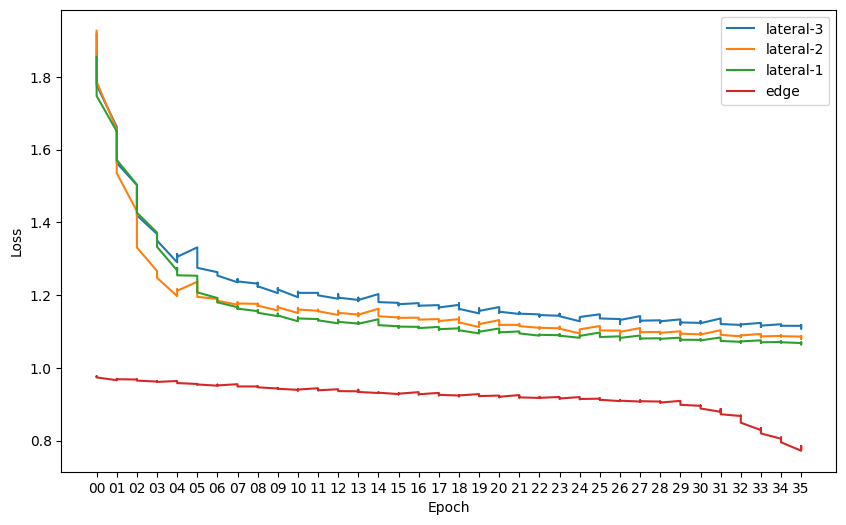

In [1]:
import matplotlib.pyplot as plt
import datetime

# 데이터 저장용 리스트
timestamps = []
epochs = []
losses_lateral3 = []
losses_lateral2 = []
losses_lateral1 = []
losses_edge = []

# 텍스트 파일 경로
txt_file = '/content/drive/MyDrive/BGNet/BGNet_FT_AG_100.txt'

# 텍스트 파일 읽기
with open(txt_file, 'r') as f:
    lines = f.readlines()

# 각 줄에 대해 데이터 추출
for line in lines:
    if 'Epoch' in line:  # Epoch 정보 추출
        timestamp = datetime.datetime.strptime(line.split()[0] + ' ' + line.split()[1], '%Y-%m-%d %H:%M:%S.%f')
        timestamps.append(timestamp)
        epoch = line.split()[3].split('/')[0][2:]
        epochs.append(epoch)

        # 손실 값들 추출
        loss_values = line.split("[")[1:]

        # 손실 값들을 순회하며 추출
        lateral3 = None
        lateral2 = None
        lateral1 = None
        edge = None

        for loss in loss_values:
            if 'lateral-3' in loss:
                lateral3 = float(loss.split(":")[1].replace(",", "").replace("]", "").strip())
            elif 'lateral-2' in loss:
                lateral2 = float(loss.split(":")[1].replace(",", "").replace("]", "").strip())
            elif 'lateral-1' in loss:
                lateral1 = float(loss.split(":")[1].replace(",", "").replace("]", "").strip())
            elif 'edge' in loss:
                edge = float(loss.split(":")[1].replace(",", "").replace("]", "").strip())

        # 추출한 손실 값들을 각 리스트에 추가
        losses_lateral3.append(lateral3)
        losses_lateral2.append(lateral2)
        losses_lateral1.append(lateral1)
        losses_edge.append(edge)

# 손실 값들 시각화
plt.figure(figsize=(10, 6))
plt.plot(epochs, losses_lateral3, label='lateral-3')
plt.plot(epochs, losses_lateral2, label='lateral-2')
plt.plot(epochs, losses_lateral1, label='lateral-1')
plt.plot(epochs, losses_edge, label='edge')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
torch.cuda.empty_cache()

Test
- 마찬가지로 parser 부분 변경
- pth_path 를 위에서 학습한 모델로 알맞게 변경
- 우리는 test dataset 자체가 하나라서 반복문 제거


In [ ]:
import imageio
import torch
import torch.nn.functional as F
import numpy as np
import os, argparse
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# 수정부분
from net.bgnet import Net
# from net.bgnet_freeze_until_EFM import Net
# from net.bgnet_freeze_until_EAM import Net
# from net.bgnet_freeze_only_backbone import Net

from utils.tdataloader import test_dataset
import easydict

# parser = argparse.ArgumentParser()
# parser.add_argument('--testsize', type=int, default=416, help='testing size')
# parser.add_argument('--pth_path', type=str, default='./checkpoints/best/BGNet.pth')

# 수정 부분
data_path = '/content/drive/MyDrive/Dataset/Test/'
save_path = '/content/drive/MyDrive/Evaluation/pred/BGNet_freeze/BI/BlackIce/'
# 수정 부분
opt = easydict.EasyDict({
  "testsize" : 416,
  "pth_path" : "/content/drive/MyDrive/BGNet/checkpoints/BGNet_FT_AG_freeze_only_backbone/BGNet_fine_tuning_freeze_only_backbone-19.pth"

})
model = Net()
model.load_state_dict(torch.load(opt.pth_path))
model.cuda()
model.eval()

os.makedirs(save_path, exist_ok=True)
os.makedirs(save_path+'edge/', exist_ok=True)
# 수정 부분
image_root = '{}/Img/'.format(data_path)
gt_root = '{}/Mask/'.format(data_path)
test_loader = test_dataset(image_root, gt_root, opt.testsize)

for i in range(test_loader.size):
    image, gt, name = test_loader.load_data()
    gt = np.asarray(gt, np.float32)
    gt /= (gt.max() + 1e-8)
    image = image.cuda()

    _, _, res, e = model(image)
    res = F.upsample(res, size=gt.shape, mode='bilinear', align_corners=False)
    res = res.sigmoid().data.cpu().numpy().squeeze()
    res = (res - res.min()) / (res.max() - res.min() + 1e-8)
    imageio.imwrite(save_path+name, (res*255).astype(np.uint8))
    e = F.upsample(e, size=gt.shape, mode='bilinear', align_corners=True)
    e = e.data.cpu().numpy().squeeze()
    e = (e - e.min()) / (e.max() - e.min() + 1e-8)
    imageio.imwrite(save_path+'edge/'+name, (e*255).astype(np.uint8))


#Evaluating

eval-co-sod 로 시도

In [ ]:
!pip install easydict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Running setup.py install for easydict ... done


In [ ]:
import easydict
from easydict import EasyDict

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/BGNet/eval_co_sod')

In [ ]:
# main.py

import torch
import torch.nn as nn
import argparse
import os.path as osp
import os
from evaluator import Eval_thread
from dataloader import EvalDataset


def main(cfg):
    root_dir = cfg.root_dir
    if cfg.save_dir is not None:
        output_dir = cfg.save_dir
    else:
        output_dir = root_dir
    gt_dir = osp.join(root_dir, 'gt')
    pred_dir = osp.join(root_dir, 'pred')
    if cfg.methods is None:
        method_names = os.listdir(pred_dir)
    else:
        method_names = cfg.methods.split('+')
    if cfg.datasets is None:
        dataset_names = os.listdir(gt_dir)
    else:
        dataset_names = cfg.datasets.split('+')

    threads = []
    for dataset in dataset_names:
        for method in method_names:
            loader = EvalDataset(osp.join(pred_dir, method, dataset),
                                 osp.join(gt_dir, dataset))
            thread = Eval_thread(loader, method, dataset, output_dir, cfg.cuda)
            threads.append(thread)
    for thread in threads:
        print(thread.run())


if __name__ == '__main__':
    # 수정부분
    config = easydict.EasyDict({
        "methods" : 'BGNet_freeze',
        "datasets" : 'BI',
        "root_dir" : '/content/drive/MyDrive/Evaluation/',
        "save_dir" : '/content/drive/MyDrive/Evaluation/results/',
        "cuda" : True
    })
    main(config)

# if __name__ == "__main__":
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--methods', type=str, default=None)
#     parser.add_argument('--datasets', type=str, default=None)
#     parser.add_argument('--root_dir', type=str, default='./')
#     parser.add_argument('--save_dir', type=str, default=None)
#     parser.add_argument('--cuda', type=bool, default=True)
#     config = parser.parse_args()
#     main(config)



eval[MAE]:BI dataset with BGNet_freeze method.
eval[FMeasure]:BI dataset with BGNet_freeze method.
eval[AP]:BI dataset with BGNet_freeze method.
eval[AUC]:BI dataset with BGNet_freeze method.
eval[EMeasure]:BI dataset with BGNet_freeze method.
eval[SMeasure]:BI dataset with BGNet_freeze method.
[cost:194.2741s] BI (BGNet_freeze): 0.0560 mae || 0.0632 max-fm || 0.0283 mean-fm || 0.4130 max-Emeasure || 0.3511 mean-Emeasure || 0.7686 S-measure || 0.0206 AP || 0.2758 AUC.


### 그래프

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import torch
import easydict

styles = ['.-r', '.--b', '.--g', '.--c', '.-m', '.-y', '.-k', '.-c']
lines = ['-', '--', '--', '--', '-', '-', '-', '-']
points = ['*', '.', '.', '.', '.', '.', '.', '.']
colors = ['r', 'b', 'g', 'c', 'm', 'orange', 'k', 'navy']


def main(cfg):
    method_names = cfg.methods.split('+')
    dataset_names = cfg.datasets.split('+')
    os.makedirs(cfg.out_dir, exist_ok=True)
    # plt.style.use('seaborn-white')

    # Plot PR Cureve
    for dataset in dataset_names:
        plt.figure()
        idx_style = 0
        for method in method_names:
            iRes = torch.load(
                os.path.join(cfg.res_dir, dataset + '_' + method + '.pth'))
            imax = np.argmax(iRes['Fm'])
            plt.plot(
                iRes['Recall'],
                iRes['Prec'],
                #  styles[idx_style],
                color=colors[idx_style],
                linestyle=lines[idx_style],
                marker=points[idx_style],
                markevery=[imax, imax],
                label=method)
            idx_style += 1

        plt.grid(True, zorder=-1)
        # plt.xlim(0, 1)
        # plt.ylim(0, 1.02)
        plt.ylabel('Precision', fontsize=25)
        plt.xlabel('Recall', fontsize=25)

        plt.legend(loc='lower left', prop={'size': 15})
        plt.savefig(os.path.join(cfg.out_dir, 'PR_' + dataset + '.png'),
                    dpi=600,
                    bbox_inches='tight')
        plt.close()

    # Plot Fm Cureve
    for dataset in dataset_names:
        plt.figure()
        idx_style = 0
        for method in method_names:
            iRes = torch.load(
                os.path.join(cfg.res_dir, dataset + '_' + method + '.pth'))
            imax = np.argmax(iRes['Fm'])
            plt.plot(
                np.arange(0, 255),
                iRes['Fm'],
                #  styles[idx_style],
                color=colors[idx_style],
                linestyle=lines[idx_style],
                marker=points[idx_style],
                label=method,
                markevery=[imax, imax])
            idx_style += 1
        plt.grid(True, zorder=-1)
        # plt.ylim(0, 1)
        plt.ylabel('F-measure', fontsize=25)
        plt.xlabel('Threshold', fontsize=25)

        plt.legend(loc='lower left', prop={'size': 15})
        plt.savefig(os.path.join(cfg.out_dir, 'Fm_' + dataset + '.png'),
                    dpi=600,
                    bbox_inches='tight')
        plt.close()

    # Plot Em Cureve
    for dataset in dataset_names:
        plt.figure()
        idx_style = 0
        for method in method_names:
            iRes = torch.load(
                os.path.join(cfg.res_dir, dataset + '_' + method + '.pth'))
            imax = np.argmax(iRes['Em'])
            plt.plot(
                np.arange(0, 255),
                iRes['Em'],
                #  styles[idx_style],
                color=colors[idx_style],
                linestyle=lines[idx_style],
                marker=points[idx_style],
                label=method,
                markevery=[imax, imax])
            idx_style += 1
        plt.grid(True, zorder=-1)
        plt.ylim(0, 1)
        plt.ylabel('E-measure', fontsize=16)
        plt.xlabel('Threshold', fontsize=16)

        plt.legend(loc='lower left', prop={'size': 15})
        plt.savefig(os.path.join(cfg.out_dir, 'Em_' + dataset + '.png'),
                    dpi=600,
                    bbox_inches='tight')
        plt.close()

    # Plot ROC Cureve
    for dataset in dataset_names:
        plt.figure()
        idx_style = 0
        for method in method_names:
            iRes = torch.load(
                os.path.join(cfg.res_dir, dataset + '_' + method + '.pth'))
            imax = np.argmax(iRes['Fm'])
            plt.plot(
                iRes['FPR'],
                iRes['TPR'],
                #  styles[idx_style][1:],
                color=colors[idx_style],
                linestyle=lines[idx_style],
                label=method)
            idx_style += 1

        plt.grid(True, zorder=-1)
        plt.xlim(0, 1)
        plt.ylim(0, 1.02)
        plt.ylabel('TPR', fontsize=16)
        plt.xlabel('FPR', fontsize=16)

        plt.legend(loc='lower right')
        plt.savefig(os.path.join(cfg.out_dir, 'ROC_' + dataset + '.png'),
                    dpi=600,
                    bbox_inches='tight')
        plt.close()

    # Plot Sm-MAE
    for dataset in dataset_names:
        plt.figure()
        plt.gca().invert_xaxis()
        idx_style = 0
        for method in method_names:
            iRes = torch.load(
                os.path.join(cfg.res_dir, dataset + '_' + method + '.pth'))
            plt.scatter(iRes['MAE'],
                        iRes['Sm'],
                        marker=points[idx_style],
                        c=colors[idx_style],
                        s=120)
            plt.annotate(method,
                         xy=(iRes['MAE'], iRes['Sm']),
                         xytext=(iRes['MAE'] - 0.001, iRes['Sm'] - 0.001),
                         fontsize=14)
            idx_style += 1

        plt.grid(True, zorder=-1)
        # plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.ylabel('S-measure', fontsize=16)
        plt.xlabel('MAE', fontsize=16)
        plt.savefig(os.path.join(cfg.out_dir, 'Sm-MAE_' + dataset + '.png'),
                    bbox_inches='tight')
        plt.close()


if __name__ == "__main__":
    config = easydict.EasyDict({
    "methods" : "BGNet_100+BGNet_NOT+BGNet_EAM+BGNet_EFM+BGNet_CAM+SINet-V2_NCD_25+SINet-V2_RFB_25",
    "datasets" : "BI",
    "res_dir" : "/content/drive/MyDrive/Evaluation/results/Detail/",
    "out_dir" : "/content/drive/MyDrive/Evaluation/results/Graph/"
    })
    # parser = argparse.ArgumentParser()
    # parser.add_argument('—methods', type=str, default=None)
    # parser.add_argument('—datasets', type=str, default=None)
    # parser.add_argument('—res_dir', type=str, default='./')
    # parser.add_argument('—out_dir', type=str, default=None)
    # config = parser.parse_args()
    main(config)

In [ ]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "3"

# import cv2
# from tqdm import tqdm
# # from py_sod_metrics import MAE, Emeasure, Fmeasure, Smeasure, WeightedFmeasure
# # from py_sod_metrics.sod_metrics import (
# #     MAE,
# #     Emeasure,
# #     Fmeasure,
# #     Smeasure,
# #     WeightedFmeasure,
# # )



# # 수정 부분 : try4 으로 수정
# method='BGNet_try4'
# # 수정 부분
# mask_root = '/content/drive/MyDrive/BGNet/data/Test/Seg'
# pred_root = '/content/drive/MyDrive/BGNet/results/{}/'.format(method)
# mask_name_list = sorted(os.listdir(mask_root))
# FM = Fmeasure()
# WFM = WeightedFmeasure()
# SM = Smeasure()
# EM = Emeasure()
# M = MAE()
# for mask_name in tqdm(mask_name_list, total=len(mask_name_list)):
#     mask_path = os.path.join(mask_root, mask_name)
#     pred_path = os.path.join(pred_root, mask_name)
#     mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
#     pred = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
#     FM.step(pred=pred, gt=mask)
#     WFM.step(pred=pred, gt=mask)
#     SM.step(pred=pred, gt=mask)
#     EM.step(pred=pred, gt=mask)
#     M.step(pred=pred, gt=mask)

# fm = FM.get_results()["fm"]
# wfm = WFM.get_results()["wfm"]
# sm = SM.get_results()["sm"]
# em = EM.get_results()["em"]
# mae = M.get_results()["mae"]

# results = {
#     "Smeasure": sm,
#     "wFmeasure": wfm,
#     "MAE": mae,
#     "adpEm": em["adp"],
#     "meanEm": em["curve"].mean(),
#     "maxEm": em["curve"].max(),
#     "adpFm": fm["adp"],
#     "meanFm": fm["curve"].mean(),
#     "maxFm": fm["curve"].max(),
# }

# print(results)
# #수정 부분
# file=open("evalresults_try4.txt", "a")
# file.write(method+' '+str(results)+'\n')
# file.close()

NameError: ignored

In [ ]:
predicct test.py{ ~~~~,~~~~<~~~~~,~~~ }

실시간성은 어려운 것이다원래 타입45ghnl

네이티브앱 = 갤럭시앱 , 아이폰앱
하이드리브앱 = 하나의 코드로 플렛폼으로 쓸수있게 개발되는

앱 -> 정책적인 부분 개인적인 보안
어려워보이니 모듈

대안 -> 웹앱 웹브라우저 동작 웹뷰 ->안드로이드

자동차 이동성 서버랑 가까우면 빨리 돌아감 물리적인이미지


h컴퓨팅이 되면 빠르게 처리할수있는데 서버에서 빠른,

1. 서버에서 넣을때 인풋
2. 아웃풋

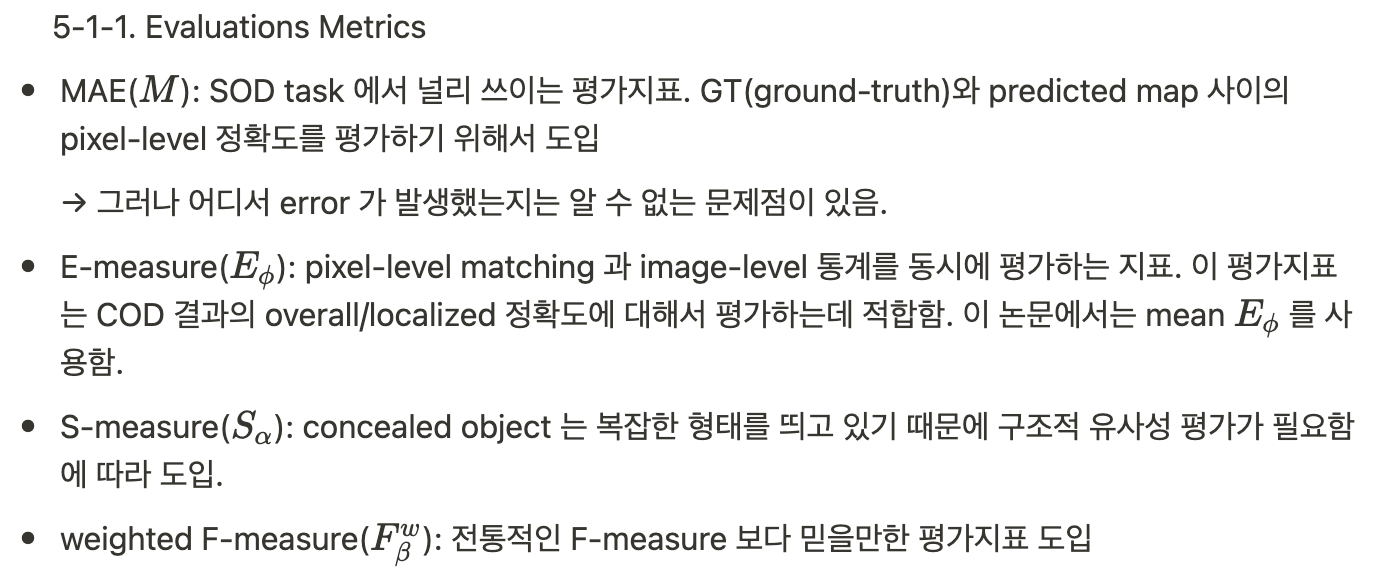

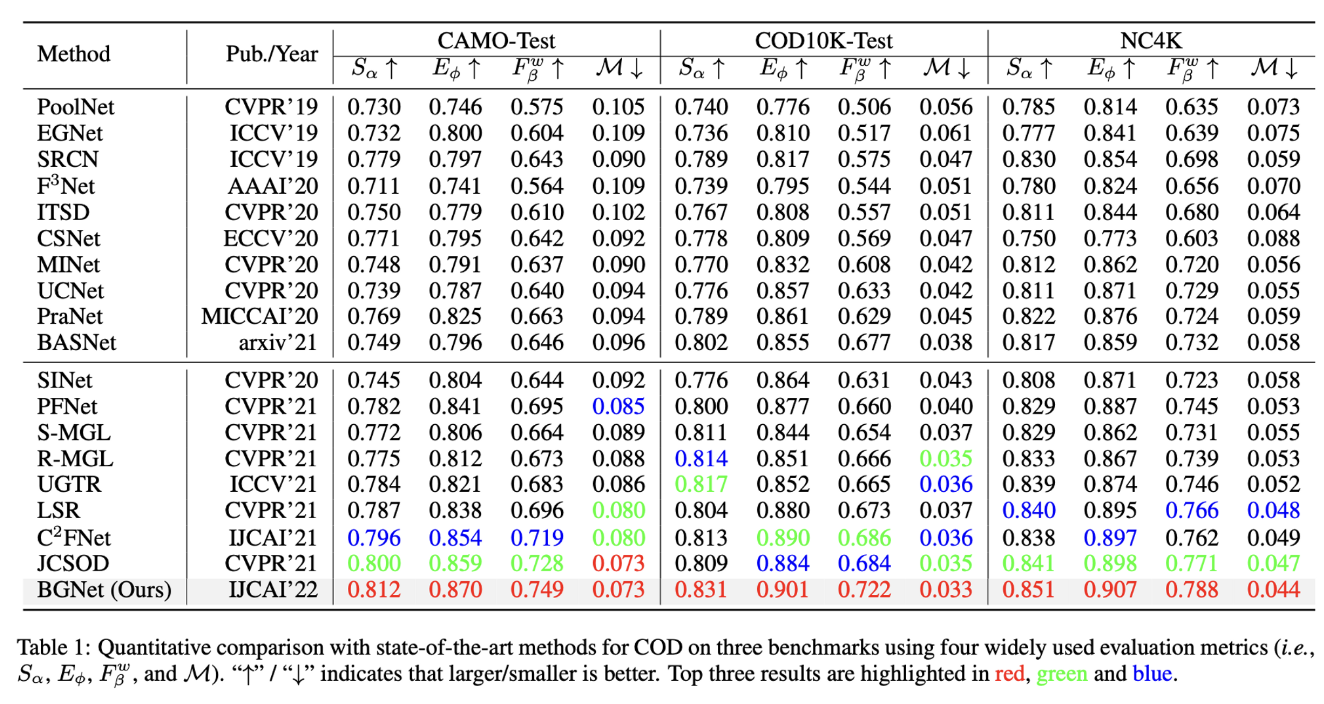

FPS / FLOPS 측정

In [ ]:
cd /content/drive/MyDrive/BGNet

/content/drive/MyDrive/BGNet


In [ ]:
!git clone https://github.com/lartpang/MethodsCmp.git

Cloning into 'MethodsCmp'...
remote: Enumerating objects: 163, done.
remote: Counting objects: 100% (163/163), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 163 (delta 56), reused 149 (delta 42), pack-reused 0
Receiving objects: 100% (163/163), 90.46 KiB | 3.77 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [ ]:
cd /content/drive/MyDrive/BGNet/MethodsCmp

/content/drive/MyDrive/BGNet/MethodsCmp


In [ ]:
import argparse
import copy

import methods
from utils.fps.fps_counter import cal_fps
from utils.num_ops_params.num_ops_params_counter import cal_macs_params_v2
import easydict


args = easydict.EasyDict({
    "method-names" : ""
})
parser = argparse.ArgumentParser(
    description="A simple toolkit for counting the FLOPs/MACs, Parameters and FPS of the model."
)
parser.add_argument(
    "--method-names", nargs="+", help="The names of the methods you want to evaluate."
)
args = parser.parse_args()

for method_name in args.method_names:
    print(f" ==>> PROCESSING THE METHOD {method_name}... <<== ")

    model_func = vars(methods).get(method_name)
    if model_func is None:
        raise KeyError(
            f"{method_name} is not be supported ({list(vars(methods).keys())})"
        )

    model_info = model_func()

    model = model_info["model"]
    data = model_info["data"]
    custom_ops = model_info.get("custom_ops", None)

    model.eval()

    num_ops, num_params = cal_macs_params_v2(
        model=copy.deepcopy(model),
        data=copy.deepcopy(data),
        custom_ops=custom_ops,
        return_flops=True,
    )
    print(f"[{method_name}] FLOPs: {num_ops}, Params: {num_params}")

    # gpu_mem = cal_gpu_mem(
    #     model=copy.deepcopy(model),
    #     data=copy.deepcopy(data),
    #     device=args.gpu,
    # )
    # print(f"[{method_name}] GPU {args.gpu} MEM: {gpu_mem}")

    fps = cal_fps(
        model=copy.deepcopy(model),
        data=copy.deepcopy(data),
        num_samples=100,
        on_gpu=True,
    )
    print(f"[{method_name}] FPS: {fps}")